In [1]:
from astropy.io import fits
import matplotlib.pyplot as plt
import aplpy
import matplotlib.pyplot as plt
import pyregion
from tqdm import tqdm
from astropy.table import QTable
import warnings
import numpy as np
import imageio.v3 as iio
from reproject import reproject_interp
import astropy.units as u

from astropy.wcs import WCS
import matplotlib as mpl
from matplotlib.colors import ListedColormap, LogNorm, Normalize, PowerNorm
from astropy.coordinates import SkyCoord
import colorcet

warnings.filterwarnings("ignore")
plt.style.use('paper')

In [2]:
hdu_12m = fits.open('./data_aces/12m_continuum_mosaic.fits')[0]
hdu_12m_tp = fits.open('./data_aces/12m_continuum_commonbeam_circular_reimaged_mosaic_MUSTANGfeathered.fits')[0]

hdu_12m.data = hdu_12m.data * 1e3
hdu_12m.writeto('./data_aces/12m_continuum_mosaic_mJy.fits', overwrite=True)

In [3]:
wcs = WCS(hdu_12m.header)
xlim1_world = -0.6 
ylim1_world = -0.3
xlim2_world = 0.9
ylim2_world = 0.25

xlim1, ylim1 = wcs.world_to_pixel(SkyCoord(xlim1_world, ylim1_world, unit=(u.deg, u.deg), frame='galactic'))
xlim2, ylim2 = wcs.world_to_pixel(SkyCoord(xlim2_world, ylim2_world, unit=(u.deg, u.deg), frame='galactic'))

In [ ]:
def get_cmap_grey_color(data, 
                        ax, 
                        cmap1='binary', 
                        cmap2='afmhot', 
                        vmin1=None, 
                        vmax1=None, 
                        vmax2=None, 
                        sigma=1,
                        pmax2=99.9,
                        norm1=Normalize(), 
                        norm2=LogNorm()):
    """  Function to plot two images with different colormaps and scales.

    Parameters
    ----------
    data : 2D numpy array 
        Data to be plotted.
    ax : matplotlib axis
        Axis to plot the data.
    cmap1 : str, optional
        Colormap for the first image. Default is 'binary'.
    cmap2 : str, optional
        Colormap for the second image. Default is 'afmhot'.
    vmin1 : float, optional
        Minimum value for the first image. Default is None.
    vmax1 : float, optional
        Maximum value for the first image. Default is None.
    vmax2 : float, optional
        Maximum value for the second image. Default is None.
    sigma : float, optional
        Number of standard deviations for the first image. Default is 1.
    pmax2 : float, optional
        Percentile for the second image. Default is 99.9.
    norm1 : matplotlib.colors.Normalize, optional
        Normalization for the first image. Default is Normalize().
    norm2 : matplotlib.colors.Normalize, optional  
        Normalization for the second image. Default is LogNorm().

    Returns
    -------
    ax : matplotlib axis
        Axis with the two images plotted.
    im1 : matplotlib image
        First image plotted - for colorbar.
    im2 : matplotlib image
        Second image plotted - for colorbar.
    
    """
    
    # Set the limits for the first image
    if vmin1 is None:
        from astropy.stats import mad_std 
        std = mad_std(data, ignore_nan=True) # MAD standard deviation
        vmin1 = -sigma*std # Lower limit
        vmax1 = sigma*std # Upper limit
        vmax2 = np.nanpercentile(data, pmax2) # Upper limit for the second image

    norm1.vmin = vmin1 #Set the limits
    norm1.vmax = vmax1 
    norm2.vmin = vmax1
    norm2.vmax = vmax2
    norm1.clip = True # Clip the values outside the limits
    norm2.clip = True

    im1 = ax.imshow(data, origin='lower', cmap=cmap1, norm=norm1) # Plot the first image
    
    # Set the values below the upper limit to NaN - so not plotted over first image...
    data_new = data.copy() # Copy the data
    data_new[data_new < vmax1] = np.nan # Set the values below the upper limit to NaN

    im2 = ax.imshow(data_new, origin='lower', cmap=cmap2, norm=norm2, interpolation='none') # Plot the second image

    return(ax, im1, im2)

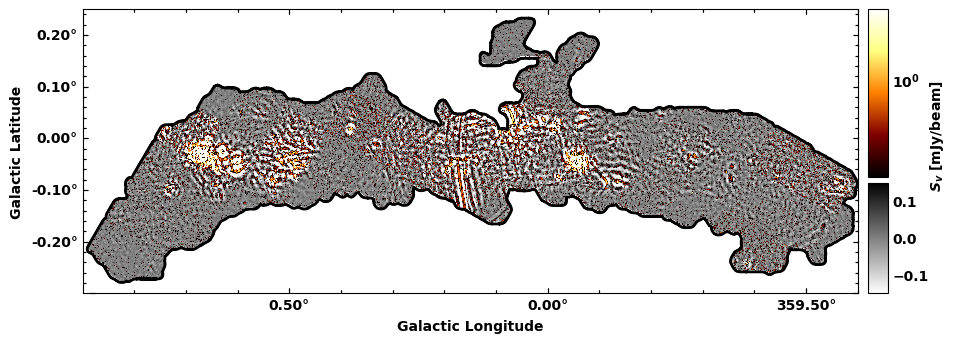

In [7]:
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection=WCS(hdu_12m.header))

ax, im1, im2 = get_cmap_grey_color(hdu_12m.data, ax)

cax1 = fig.add_axes([ax.get_position().x1+0.01, ax.get_position().y0, 0.02, ax.get_position().height*0.39])
cax2 = fig.add_axes([ax.get_position().x1+0.01, ax.get_position().y0+ax.get_position().height*0.41, 0.02, ax.get_position().height*0.59])

cba = plt.colorbar(im1, cax=cax1)
cba = plt.colorbar(im2, cax=cax2)

cax2.text(3, 0.25, '$S_v$ [mJy/beam]', rotation=90, va='center', ha='left', transform=cax2.transAxes)

mask = (np.isnan(hdu_12m.data)==0)*1
ax.contour(mask, levels=[1], colors='black', linewidths=2)

ax.set_xlabel('Galactic Longitude')
ax.set_ylabel('Galactic Latitude')

lon = ax.coords['glon']
lat = ax.coords['glat']

lon.set_major_formatter('d.dd')
lat.set_major_formatter('d.dd')

lon.display_minor_ticks(True)
lat.display_minor_ticks(True)

ax.set_xlim(xlim2, xlim1)
ax.set_ylim(ylim1, ylim2)

ax.grid(True, alpha=0.3, ls=':', color='white')

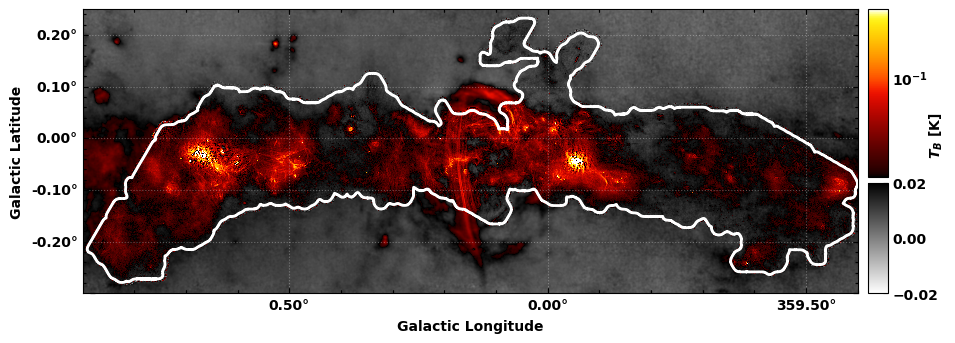

In [9]:
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection=WCS(hdu_12m_tp.header))

ax, im1, im2 = get_cmap_grey_color(hdu_12m_tp.data, 
                                   ax, 
                                   vmin1 = -0.02, 
                                   vmax1 = 0.02, 
                                   vmax2 = 0.3, 
                                   cmap2='cet_fire')

cax1 = fig.add_axes([ax.get_position().x1+0.01, ax.get_position().y0, 0.02, ax.get_position().height*0.39])
cax2 = fig.add_axes([ax.get_position().x1+0.01, ax.get_position().y0+ax.get_position().height*0.41, 0.02, ax.get_position().height*0.59])

cba = plt.colorbar(im1, cax=cax1)
cba = plt.colorbar(im2, cax=cax2)

cax2.text(3, 0.25, '$T_B$ [K]', rotation=90, va='center', ha='left', transform=cax2.transAxes)

mask = (np.isnan(hdu_12m.data)==0)*1
ax.contour(mask, levels=[1], colors='white', linewidths=2)

ax.set_xlabel('Galactic Longitude')
ax.set_ylabel('Galactic Latitude')

lon = ax.coords['glon']
lat = ax.coords['glat']

lon.set_major_formatter('d.dd')
lat.set_major_formatter('d.dd')

lon.display_minor_ticks(True)
lat.display_minor_ticks(True)

ax.set_xlim(xlim2, xlim1)
ax.set_ylim(ylim1, ylim2)


ax.grid(True, alpha=0.3, ls=':', color='white')